## Code to have 2D Maxwell (with B in the direction z) using SummationByParts operators.

This is to be ported to the PIC code.

In [45]:
using Plots
using SummationByPartsOperators
using LinearAlgebra

In [5]:
include("../../PIC/PIC-1D/aux_functions/aux_functions_grid.jl")

get_index_and_y_alt! (generic function with 1 method)

In [81]:
J = (200,100)
Box = (0.0,2.0,0.0,1.0)
dx = differentials(Box,J)
D = 2

xv = [(i-1)*dx[1] for i in 1:J[1]]
yv = [(i-1)*dx[2] for i in 1:J[2]];

In [82]:
Dx = periodic_derivative_operator(derivative_order=1, accuracy_order=6, xmin=Box[1], xmax=Box[2], N=J[1])
Dy = periodic_derivative_operator(derivative_order=1, accuracy_order=6, xmin=Box[3], xmax=Box[4], N=J[2])

Periodic first-derivative operator of order 6 on a grid in [0.0, 1.0] using 100 nodes, 
stencils with 3 nodes to the left, 3 nodes to the right, and coefficients of Fornberg (1998) 
  Calculation of Weights in Finite Difference Formulas. 
  SIAM Rev. 40.3, pp. 685-691.

### Single array version 

In [83]:
k = 2π*[3,3]
fe(x,y) = sin(k[1]*x)*sin(k[2]*y)
Ea = [(-1)^l*fe(xv[i],yv[j]) for l in 1:2, i in 1:J[1], j in 1:J[2]];

#grad_Ea = [(-1)^l * ( (2-m)*k[1]*cos(k[1]*xv[i])*sin(k[2]*yv[j]) + (m-1)*k[2]*sin(k[1]*xv[i])*cos(k[2]*yv[j]) ) for m in 1:2, for l in 1:2, i in 1:J[1], j in 1:J[2] ];

grad_Ea = Array{Float64,4}(undef,(D,D,J...))
grad_sbp_Ea = Array{Float64,4}(undef,(D,D,J...))

for m in 1:2
    for l in 1:2
        for i in 1:J[1]
            for j in 1:J[2]
            grad_Ea[m,l,i,j] = (-1)^l * ( (2-m)*k[1]*cos(k[1]*xv[i])*sin(k[2]*yv[j]) + (m-1)*k[2]*sin(k[1]*xv[i])*cos(k[2]*yv[j]) )
            end
        end
    end
end

In [84]:
norm(Ea)

100.0

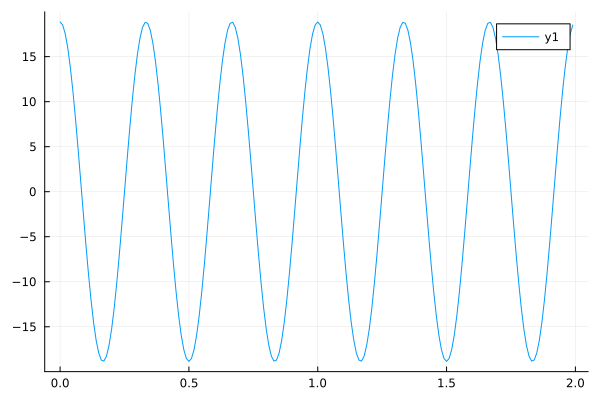

In [85]:
size(Dx)

u = sin.(k[1]*xv)
du = similar(u)
mul!(du,Dx,u)

plot(xv,du)

In [86]:
size(Ea)
size(grad_sbp_Ea)

(2, 2, 200, 100)

In [87]:
grad_sbp_Ea .= 0.0

for l in 1:2
    #for i in 1:J[1]
        for j in 1:J[2]
            mul!(view(grad_sbp_Ea,1,l,:,j), Dx, view(Ea,l,:,j),
            one(eltype(grad_sbp_Ea)), one(eltype(grad_sbp_Ea)))
        end
    #end
end

for l in 1:2
    for i in 1:J[1]
        #for j in 1:J[2]
            mul!(view(grad_sbp_Ea, 2,l,i,:), Dy, view(Ea,l,i,:),
            one(eltype(grad_sbp_Ea)), one(eltype(grad_sbp_Ea)))
        #end
    end
end

In [88]:
grad_sbp_Ea[2,2,:,:]

200×100 Matrix{Float64}:
   0.0        0.0        0.0      …    0.0        0.0        0.0
   3.53205    3.46949    3.28402       2.98221    3.28402    3.46949
   6.93898    6.81607    6.4517        5.85878    6.4517     6.81607
  10.1001     9.92119    9.39083       8.52779    9.39083    9.92119
  12.9034    12.6749    11.9973       10.8947    11.9973    12.6749
  15.2496    14.9795    14.1787   …   12.8757    14.1787    14.9795
  17.0556    16.7535    15.8579       14.4005    15.8579    16.7535
  18.2574    17.934     16.9753       15.4152    16.9753    17.934
  18.8124    18.4791    17.4913       15.8838    17.4913    18.4791
  18.7009    18.3697    17.3877       15.7897    17.3877    18.3697
   ⋮                              ⋱                        
 -18.7009   -18.3697   -17.3877      -15.7897   -17.3877   -18.3697
 -18.8124   -18.4791   -17.4913      -15.8838   -17.4913   -18.4791
 -18.2574   -17.934    -16.9753      -15.4152   -16.9753   -17.934
 -17.0556   -16.7535   -15.8579  

In [89]:
norm(grad_sbp_Ea - grad_Ea)

0.0008481920847130507